In [1]:
# usual imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
%matplotlib inline
import datetime as dt
from  scipy.stats import chisquare
from scipy.stats import chi2_contingency


# stats tests 
from scipy.stats import ttest_ind

# ml imports
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn import datasets

In [2]:
# read in the data
data = pd.read_csv("KaggleV2-May-2016.csv", parse_dates=["AppointmentDay", "ScheduledDay"])

### Initial data cleaning
###### For details see other notebooks

In [3]:
# filter out negative age
data = data[data.Age >=0]

# This turns the No-show variable into a binary of true or false where true means a no-show.  
data['no_show_bi'] = data["No-show"]== 'Yes'

# Create a column that is the day of the week of the appointment 
data["appointment_day"] = data["AppointmentDay"].dt.weekday_name

# Remove the Saturday appointments as they are clearly outliers. 
data= data[data["appointment_day"] != "Saturday"]

# create a column for the time between when a patient scheduled the appointment to the appointment.
data["wait"] = (data["AppointmentDay"].dt.date - data["ScheduledDay"].dt.date)

# drop negative wait time rows. 
data = data[data['wait'] >= "0 days"]

# remove outlier neighbourhoods
remove_list = ["ILHA DO BOI", "ILHA DO FRADE", "AEROPORTO", "ILHAS OCEÂNICAS DE TRINDADE","PARQUE INDUSTRIAL"]
data= data[~data.Neighbourhood.isin(remove_list)]

## Implement Binning System 
### Age Binning

In [4]:
def bin_age(df):
    '''Creates a function to turn age into 6 groups of binned ages.'''
                        # bin ranges 0-3, 4-7, 8-27, 28-40, 41-60, 61 < 
    if df["Age"] <4:
        return 2
    elif df["Age"] <8:
        return 5
    elif df["Age"] <28:
        return 16
    elif df["Age"] <41:
        return 34
    elif df["Age"] <61:
        return 51
    else:
        return 70

In [5]:
# apply binning function
data["Age_Binned"]= data.apply(bin_age, axis=1)

### Wait time binning

In [6]:
# turn wait time from time delta to an int
data["days_waiting"] = data["wait"].dt.days

In [7]:
def bin_wait_time(df):
    '''Creates a function to turn wait_time into 5 groups of binned wait times .'''
                        # bin ranges 0, 1, 2-4, 5-9, 10 < 
    col="days_waiting"
    if df[col]   <1:
        return 0
    elif df[col] <2:
        return 1
    elif df[col] <5:
        return 3
    elif df[col] <10:
        return 7
    else:
        return 15

In [8]:
# Apply the binning function. 
data["Wait_Binned"]= data.apply(bin_wait_time, axis=1)

# MACHINE LEARNING SECTION

Mentor notes: 
+ need to get data into correct format 
+ split / cross validation change –  logistic regression cv. 
+ create a machine learning pipeline -  MLP 
+ logistic regression. – over sampled / undersampled  ROV curve area under curve Grid search. 
+ knn
+ Random forest 
+ SVM - support vector machine 
+ Get some results full machine learning from begining to end. 


In [9]:
data.columns

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show',
       'no_show_bi', 'appointment_day', 'wait', 'Age_Binned', 'days_waiting',
       'Wait_Binned'],
      dtype='object')

In [10]:
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,no_show_bi,appointment_day,wait,Age_Binned,days_waiting,Wait_Binned
0,2.987250e+13,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,False,Friday,0 days,70,0,0
1,5.589978e+14,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,False,Friday,0 days,51,0,0
2,4.262962e+12,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,False,Friday,0 days,70,0,0
3,8.679512e+11,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,False,Friday,0 days,16,0,0
4,8.841186e+12,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,False,Friday,0 days,51,0,0


## Wrangle the data into a form where ml can be applied

#### We will run the follow ml algorithms on the best features in our data.

In [12]:
# Run cell to run ML on only the best predictor variables.
X_create= data.set_index("AppointmentID")[["SMS_received","Age_Binned", "Wait_Binned","Neighbourhood"]]
X_create["Age_Binned"]=X_create["Age_Binned"].astype(str)
X_create["Wait_Binned"]=X_create["Wait_Binned"].astype(str)
y_create = data.set_index("AppointmentID")[["No-show"]]
y_create["No-show"][y_create["No-show"]=="Yes"] = 1
y_create["No-show"][y_create["No-show"]=="No"]  = 0
X_create.head(2)

,SMS_received,Age_Binned,Wait_Binned,Neighbourhood
AppointmentID,,,,
5642903,0,70,0,JARDIM DA PENHA
5642503,0,51,0,JARDIM DA PENHA


In [13]:
# make the categorical variables into bool columns, drop the first to avoid redundancy. 
X = pd.get_dummies(X_create, drop_first=True).values

# This puts the y values which are our targets into the correct format for ml 
y = np.array(list(y_create["No-show"]))

In [29]:
# we split the data at this point to set aside 20% of the data for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=12)

## Rebalance the data with SMOTE

In [30]:
# split the data again for independent data to rebalance. 
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train, y_train,
                                                  test_size = .1,
                                                  random_state=12)
# run the rebalancing algorithm on data. 
smote = SMOTE(random_state=12 , ratio='minority') 
x_train_res, y_train_res = smote.fit_sample(X_train2, y_train2)

### Logistic Regression 

In [15]:
# run logistic regression with cross validation on the top variables. 
searchCV = LogisticRegressionCV(cv=10, scoring = 'f1')
searchCV.fit(X_train, y_train)
y_pred_LR = searchCV.predict(X_test)

C:\Users\dovidb\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [16]:
print(classification_report(y_test, y_pred_LR))
# We have predicted almost no no-shows with Logistic Regression, f1-score is 0.01

             precision    recall  f1-score   support

          0       0.80      1.00      0.89     17621
          1       0.45      0.01      0.01      4465

avg / total       0.73      0.80      0.71     22086



In [41]:
# attempt at changing the threshold with predict_proba
y_pred_prob_LR = searchCV.predict_proba(X_test)[:,1] >.21
print(classification_report(y_test, y_pred_prob_LR))

             precision    recall  f1-score   support

          0       0.92      0.53      0.67     17621
          1       0.31      0.82      0.45      4465

avg / total       0.80      0.59      0.63     22086



In [28]:
# we see that the with a lower threshold of 0.21 we get a much better f1-score
metrics.f1_score(y_test, y_pred_prob_LR)

0.4464285714285714

In [42]:
# we don't have a great a accuracy. 
accuracy_score(y_test,y_pred_prob_LR)

0.59014760481753148

In [17]:
# we have a decent AUROC of 0.725 
metrics.roc_auc_score(y_test,searchCV.predict_proba(X_test)[:,1])

0.72522287586588163

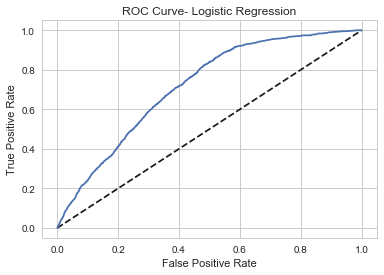

In [168]:
y_pred_prob = searchCV.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Logistic Regression')
plt.show()

## Logistic Regression with rebalanced data

In [31]:
# run logistical regression with built in cross validation, maximizing f1-score, on the rebalanced data
searchCV_SMOTE = LogisticRegressionCV(cv=10, scoring= "f1")
searchCV_SMOTE.fit(x_train_res, y_train_res)
y_pred_LR = searchCV_SMOTE.predict(X_test)

In [32]:
# We see that the rebalanced data has a better f1-score with the regular threshold of 0.5 
print(classification_report(y_test, searchCV_SMOTE.predict(X_test)))

             precision    recall  f1-score   support

          0       0.92      0.53      0.67     17621
          1       0.31      0.82      0.45      4465

avg / total       0.80      0.59      0.63     22086



In [33]:
metrics.roc_auc_score(y_test,searchCV_SMOTE.predict_proba(X_test)[:,1])

0.72400725923010145

In [58]:
# show how the f1-score and the accuracy of the algorithm change with different thresholds. 
thresh_list = np.arange(0.4,0.6,0.01)  
lr_cv_proba = searchCV_SMOTE.predict_proba(X_test)[:,1]
print("Threshold---f1-score---accuracy")
for value in thresh_list:
    prediction = lr_cv_proba > value
    f1_score_v = metrics.f1_score(y_test,prediction)
    total_score = metrics.accuracy_score(y_test,prediction)
    print(value , f1_score_v, total_score )

Threshold---f1-score---accuracy
0.4 0.437833468068 0.527709861451
0.41 0.438359129776 0.530109571674
0.42 0.439620377441 0.534818437019
0.43 0.440402264109 0.538938694195
0.44 0.439789997237 0.541021461559
0.45 0.441017559658 0.550303359594
0.46 0.442361547694 0.558226931088
0.47 0.443320544123 0.566422167889
0.48 0.444038212053 0.573123245495
0.49 0.446046623408 0.582540976184
0.5 0.44608801956 0.589694829304
0.51 0.445881255828 0.596441184461
0.52 0.444430135222 0.609345286607
0.53 0.444840327263 0.619034682604
0.54 0.440800710528 0.629403241873
0.55 0.438982930802 0.64135651544
0.56 0.437655313551 0.651634519605
0.57 0.436596385542 0.6612333605
0.58 0.432802176448 0.669609707507
0.59 0.425860510967 0.683555193335


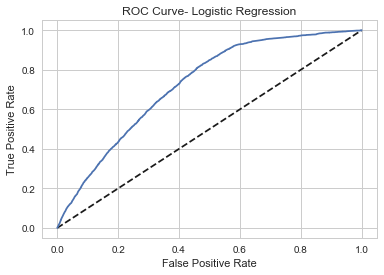

In [39]:
# Generate ROC curve values: fpr, tpr, thresholds - rebalanced data 
fpr, tpr, thresholds = roc_curve(y_test, lr_cv_proba)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Logistic Regression')
plt.show()

## Impliment K-nearest neighbors Classifier

In [242]:
# we split the data at this point to set aside 20% of the data for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=12)

In [243]:
# run with the top variables 
knn = KNeighborsClassifier(n_jobs=-1 ).fit(X_train, y_train)
knn.score(X_test,y_test)
y_pred_knn = knn.predict(X_test)

In [244]:
metrics.roc_auc_score(y_test,knn.predict_proba(X_test)[:,1])

0.6489625118354595

In [245]:
# the default f1-score is higher for knn than logistical regression without a threshold or rebalancing
metrics.f1_score(y_test, y_pred_knn)

0.24541809851088203

### Grid Search to find best number of neighbors

In [98]:
param_grid = {'n_neighbors':np.arange(4,20)}
knn = KNeighborsClassifier(n_jobs=-1)
knn_cv = GridSearchCV(knn, param_grid, cv=3,scoring= "f1")
knn_cv.fit(X_train,y_train)
knn_cv.best_params_

{'n_neighbors': 18}

In [59]:
# Re-run with 18 neighbors  
knn = KNeighborsClassifier(n_neighbors=18, n_jobs=-1 ).fit(X_train, y_train)
knn.score(X_test,y_test)
y_pred_knn = knn.predict(X_test)

In [61]:
# applying different thresholds to see how the f1-score and accuracy are effected
thresh_list = np.arange(0.1,0.36,0.01)  # k = default 
knn_proba = knn.predict_proba(X_test)[:,1]
for value in thresh_list:
    knn_sn_th = knn_proba > value
    f1_score_v = metrics.f1_score(y_test,knn_sn_th)
    accuracy = metrics.accuracy_score(y_test,knn_sn_th)
    print(value , f1_score_v, accuracy )

0.1 0.410514654044 0.469980983428
0.11 0.410514654044 0.469980983428
0.12 0.424256163219 0.540025355429
0.13 0.424256163219 0.540025355429
0.14 0.424256163219 0.540025355429
0.15 0.424256163219 0.540025355429
0.16 0.424256163219 0.540025355429
0.17 0.424190463629 0.604681698814
0.18 0.424190463629 0.604681698814
0.19 0.424190463629 0.604681698814
0.2 0.424190463629 0.604681698814
0.21 0.424190463629 0.604681698814
0.22 0.424190463629 0.604681698814
0.23 0.412384195107 0.663995291135
0.24 0.412384195107 0.663995291135
0.25 0.412384195107 0.663995291135
0.26 0.412384195107 0.663995291135
0.27 0.412384195107 0.663995291135
0.28 0.387778412336 0.708774789459
0.29 0.387778412336 0.708774789459
0.3 0.387778412336 0.708774789459
0.31 0.387778412336 0.708774789459
0.32 0.387778412336 0.708774789459
0.33 0.387778412336 0.708774789459
0.34 0.339497392129 0.747713483655
0.35 0.339497392129 0.747713483655


In [62]:
# once we optimize the algorithm, we get a better roc_auc score of .70
metrics.roc_auc_score(y_test,knn.predict_proba(X_test)[:,1])

0.69963725456614079

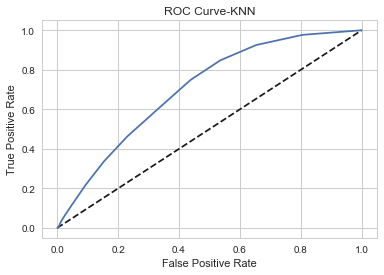

In [175]:
y_pred_prob = knn.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve-KNN')
plt.show()

## KNN with rebalanced data 

In [63]:
# Re-run with 18 neighbors  
knn_sn = KNeighborsClassifier(n_neighbors=18, n_jobs=-1 ).fit(x_train_res, y_train_res)
knn_sn.score(X_test,y_test)
y_pred_knn = knn_sn.predict(X_test)

In [64]:
# once we optimize the algorithm, we get a better roc_auc score of .70
metrics.roc_auc_score(y_test,knn_sn.predict_proba(X_test)[:,1])

0.6913706242163844

In [65]:
# this is the better f1 score with rebalancing and no threshold 
metrics.f1_score(y_test, y_pred_knn)

0.34730901028018546

In [69]:
###### applying different thresholds to see how the f1-score and accuracy are effected
thresh_list = np.arange(0.1,0.3,0.01)  # k = default 
knn_proba = knn_sn.predict_proba(X_test)[:,1]
for value in thresh_list:
    knn_sn_th = knn_proba > value
    f1_score_v = metrics.f1_score(y_test,knn_sn_th)
    accuracy = metrics.accuracy_score(y_test,knn_sn_th)
    print(value , f1_score_v, accuracy )

0.1 0.409756575403 0.454360228199
0.11 0.409756575403 0.454360228199
0.12 0.424232719509 0.511591053156
0.13 0.424232719509 0.511591053156
0.14 0.424232719509 0.511591053156
0.15 0.424232719509 0.511591053156
0.16 0.424232719509 0.511591053156
0.17 0.430785064898 0.549261975912
0.18 0.430785064898 0.549261975912
0.19 0.430785064898 0.549261975912
0.2 0.430785064898 0.549261975912
0.21 0.430785064898 0.549261975912
0.22 0.430785064898 0.549261975912
0.23 0.426701247376 0.579643212895
0.24 0.426701247376 0.579643212895
0.25 0.426701247376 0.579643212895
0.26 0.426701247376 0.579643212895
0.27 0.426701247376 0.579643212895
0.28 0.422256198896 0.606492800869
0.29 0.422256198896 0.606492800869


### Our best f1-value is 0.431 with a threshold of 0.22 and an accuracy of 0.549 

## Random Forest Classifier

In [70]:
# we split the data at this point to set aside 20% of the data for model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=12)

In [238]:
# run random forest 
rfc = RandomForestClassifier(n_jobs=-1, random_state = 42)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.79036493706420352

In [239]:
metrics.roc_auc_score(y_test,rfc.predict_proba(X_test)[:,1])

0.70412266116598976

In [241]:
print(classification_report(y_test, rfc.predict(X_test)))

             precision    recall  f1-score   support

          0       0.80      0.97      0.88      8810
          1       0.39      0.06      0.11      2233

avg / total       0.72      0.79      0.72     11043



In [85]:
# run random forest 
rfc = RandomForestClassifier(n_jobs=-1, random_state = 42, max_depth= 30, min_samples_leaf= 1, n_estimators= 9)
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.79335325545594493

In [86]:
y_pred_RF = rfc.predict(X_test)

In [88]:
metrics.roc_auc_score(y_test,rfc.predict_proba(X_test)[:,1])

0.71631443627803559

In [87]:
print(classification_report(y_test, y_pred_RF))

             precision    recall  f1-score   support

          0       0.80      0.99      0.88      8810
          1       0.35      0.03      0.05      2233

avg / total       0.71      0.79      0.71     11043



In [89]:
y_pred_prob_RF = rfc.predict_proba(X_test)[:,1] > 0.22

In [90]:
metrics.f1_score(y_test,y_pred_prob_RF)

0.43495505023796932

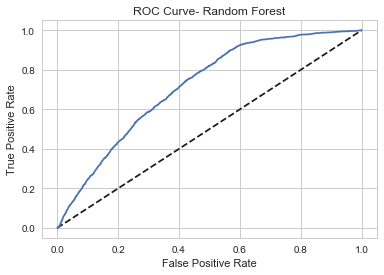

In [92]:
y_pred_prob = rfc.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Random Forest')
plt.show()

### Grid Search for Random Forest Hyperparameters 

For Grid Search CV : scoring can be  =  f1, accuracy, recall, or precision    

In [189]:
rfc = RandomForestClassifier(n_jobs=-1, random_state = 42) 
 
# Use a grid over parameters of interest
param_grid = { 
           "n_estimators" : [1,3,5,7,9, 18, 27], #36, 45, 54, 63],
           "max_depth" : [42,45,48,51,55] ,#30, 32, 34, 36, 38, 40, 42],
           "min_samples_leaf" : [1, 2, 4, 6]}
 
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 3, scoring= "f1" , n_jobs=-1)
CV_rfc.fit(X_train2, y_train2)
print (CV_rfc.best_params_)

{'max_depth': 51, 'min_samples_leaf': 1, 'n_estimators': 1}


##### {'max_depth': 51, 'min_samples_leaf': 1, 'n_estimators': 1} with resampling 

{'max_depth': 42, 'min_samples_leaf': 1, 'n_estimators': 9} with resampling 

{'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 27} using f1 : with re-sampling 

##### {'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 9} using f1  : not with re-sampling 

##### {'max_depth': 30, 'min_samples_leaf': 1, 'n_estimators': 9} - using recall 

#### From above : {'max_depth': 15, 'min_samples_leaf': 8, 'n_estimators': 27} - using accuracy. 

### We found grid search gave many different optimum parameters with different runs. 

### RF using tuned hyperperameters 

In [220]:
# run random forest 
rfc_sm = RandomForestClassifier(n_jobs=-1, random_state = 30,max_depth= 30, min_samples_leaf= 1, n_estimators= 9) #, max_depth= 30, min_samples_leaf= 1, n_estimators= 9)
# (n_jobs=-1, random_state = 42,max_depth= 30, min_samples_leaf= 1, n_estimators= 4)
rfc_sm.fit(X_train2, y_train2)
rf_sm = rfc_sm.predict(X_test)
rfc_sm.score(X_test, y_test)

0.7926288146337046

In [221]:
print("ROC_AUC = ")
print(metrics.roc_auc_score(y_test,rfc_sm.predict_proba(X_test)[:,1]))
print("F1 Score = ")
print(metrics.f1_score(y_test,rf_sm))

ROC_AUC = 
0.71668449168
F1 Score = 
0.0434419381788


In [227]:
y_rf_sm = rfc_sm.predict_proba(X_test)[:,1] > 0.17 
print("F1 Score = ")
print(metrics.f1_score(y_test,y_rf_sm))

F1 Score = 
0.435298141603


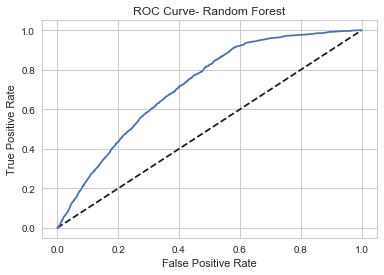

In [84]:
y_pred_rfsm = rfc_sm.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rfsm)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve- Random Forest')
plt.show()